# ML Feature enginerring - SelectKbest

In [4]:
%matplotlib inline
%run ../talibref.py
%run ensemble.py
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import time
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

### Get data

In [5]:
#df=pd.read_csv("data/IYZ.csv")
ticker = 'IYW'
startdate=datetime.date(2010, 1, 1)
enddate=datetime.date.today()
df = generate_ticker_data(ticker, startdate, enddate)

Available data: Ticker(IYW) from 2000.05.19 to 2015.11.30
Usable data: Ticker(IYW) from 2001.03.07 to 2015.11.30 
Returned data: Ticker(IYW) from 2010.01.04 to 2015.11.30 
Save path: data/IYW_from_2010.01.04_2015.11.30.csv


In [6]:
dftouse=df.copy()

### Feature Engineering

In [7]:
IGNORE = ['date', 'result_1','close_1','perf_1','result_14','close_14','perf_14','results']

In [8]:
INDICATORS=[]
for v in df.columns:
    l=df[v].unique()
    if len(l) <= 10 and v not in IGNORE:
        #print v, l
        INDICATORS.append(v)

In [9]:
STANDARDIZABLE = []
for v in df.columns:
    if v not in INDICATORS and v not in IGNORE:
        #print v
        STANDARDIZABLE.append(v)

In [10]:
################################################
# Code to add signals from other tickers
################################################

# Additional tickers to consider
moreTickers = [
               '^GSPC', #S&P500
               '^dji',  #Dow Jones Industrials
               '^IXIC', #Nasdaq
               'OIL'   #Oil price ETF
              ]

# Signals for additional tickers
STANDARDIZABLE_TO_ADD = ['roc']
INDICATORS_TO_ADD = ['sar_signal']


def addDataFromOtherTicker(tickerPlus):
    dfPlus = generate_ticker_data(tickerPlus, startdate, enddate)
    if df.shape == dfPlus.shape:
        dfPluss = dfPlus.copy()
        dfPluss = dfPluss[STANDARDIZABLE_TO_ADD+INDICATORS_TO_ADD]
        STANDARDIZABLE2 = STANDARDIZABLE_TO_ADD[:]
        INDICATORS2 = INDICATORS_TO_ADD[:]
        for p in STANDARDIZABLE2:
            renamed = p+'_'+tickerPlus
            dftouse[renamed]=dfPluss[p]*1.0
            STANDARDIZABLE.append(renamed)
        for p in INDICATORS2:
            renamed = p+'_'+tickerPlus
            dftouse[renamed]=dfPluss[p]
            INDICATORS.append(renamed)
    else:
        print "Data for additional tickers doesn't match data frame for sector of interest."

for tick in moreTickers:
    print "####### Loading data for "+tick+"...."
    addDataFromOtherTicker(tick)    
    time.sleep(0.5)
    
dftouse.head()

####### Loading data for ^GSPC....
Available data: Ticker(^GSPC) from 1950.01.03 to 2015.11.30
Usable data: Ticker(^GSPC) from 1962.05.28 to 2015.11.30 
Returned data: Ticker(^GSPC) from 2010.01.04 to 2015.11.30 
Save path: data/^GSPC_from_2010.01.04_2015.11.30.csv
####### Loading data for ^dji....
Available data: Ticker(^dji) from 1985.01.29 to 2015.11.30
Usable data: Ticker(^dji) from 1987.10.15 to 2015.11.30 
Returned data: Ticker(^dji) from 2010.01.04 to 2015.11.30 
Save path: data/^dji_from_2010.01.04_2015.11.30.csv
####### Loading data for ^IXIC....
Available data: Ticker(^IXIC) from 1971.02.05 to 2015.11.30
Usable data: Ticker(^IXIC) from 1973.11.26 to 2015.11.30 
Returned data: Ticker(^IXIC) from 2010.01.04 to 2015.11.30 
Save path: data/^IXIC_from_2010.01.04_2015.11.30.csv
####### Loading data for OIL....
Available data: Ticker(OIL) from 2006.08.16 to 2015.11.30
Usable data: Ticker(OIL) from 2007.06.05 to 2015.11.30 
Returned data: Ticker(OIL) from 2010.01.04 to 2015.11.30 
Sa

,date,open,high,low,close,volume,close_1,result_1,perf_1,close_14,result_14,perf_14,results,bb_upper,bb_middle,bb_lower,bb_pct,bb_bandwidth,bb_squeeze,bb_signalup,bb_signaldn,bb_signal,ema50,ema150,ema200,ema_signal1,ema_signal2,kama50,kama150,kama200,kama_signal1,kama_signal2,sar,sar_signal,adx,plus_di,minus_di,adx_trend,adx_direction,adx_signal,aroon_osc,aroon_signal,cci,cci_signal,macd,macd_sigline,macd_hist,macd_signal,ppo,ppo_signal,mfi,mfi_signal,roc,roc_signal,rsi,rsi_signal,ult_osc,ult_signal,willr,wr_signal,ad_osc,ad_signal,stoch_slowk,stoch_slowd,sslow_signal,stoch_fastk,stoch_fastd,srsi_signal,trix,trix_signal,sr_pivotpts,sr_res1,sr_sup1,sr_res2,sr_sup2,sr_res3,sr_sup3,cv_signal,roc_^GSPC,sar_signal_^GSPC,roc_^dji,sar_signal_^dji,roc_^IXIC,sar_signal_^IXIC,roc_OIL,sar_signal_OIL
0,2010-01-04,57.959999,58.639999,57.959999,58.490002,839500,58.400002,False,-0.001539,54.650002,False,-0.065652,0,58.821266,56.400501,53.979736,0.931579,8.584197,False,False,False,1,55.103843,50.939451,49.689076,1,1,54.934088,55.163104,54.687729,1,1,57.129425,1,25.595318,34.344404,14.198666,True,True,1,96,1,104.070198,0,0.967047,0.820124,0.146923,1,2.069180,1,77.163680,0,6.056210,0,69.456721,0,65.655670,0,-4.178189,0,323738.684607,1,68.252065,73.811019,0,74.199560,58.066520,1,0.159948,1,58.363333,63.376669,58.086668,63.653334,53.073332,68.666670,52.796667,1,3.367458,1,2.674556,1,5.888391,1,11.120401,1
1,2010-01-05,58.540001,58.639999,58.070000,58.400002,533400,57.990002,False,-0.007021,55.070000,False,-0.057021,0,59.073448,56.551501,54.029554,0.866483,8.919116,False,False,False,1,55.233104,51.038266,49.775752,1,1,55.057603,55.293977,54.853506,1,1,57.431539,1,26.731421,32.251229,13.333305,True,True,1,100,1,91.820847,0,0.985246,0.853149,0.132097,1,2.210421,1,78.400021,0,4.211279,0,68.387361,0,62.174984,0,-6.685153,0,350002.731221,1,62.175877,65.253897,0,59.847580,44.682380,1,0.162662,1,58.370000,63.390003,58.100002,63.660001,53.079999,68.680004,52.810001,1,3.088524,1,2.353882,1,4.386692,1,10.696517,1
2,2010-01-06,58.450001,58.580002,57.869999,57.990002,578900,57.770000,False,-0.003794,55.000000,False,-0.051561,0,59.199055,56.696501,54.193947,0.758436,8.827896,False,False,False,1,55.341217,51.130342,49.857486,1,1,55.152838,55.400863,54.976327,1,1,57.673231,1,27.300301,29.813769,14.454549,True,True,1,96,1,68.044885,0,0.955570,0.873633,0.081937,1,2.352947,1,72.429127,0,2.437734,0,63.584635,0,54.831713,0,-18.105766,0,206997.775002,1,69.047859,66.491934,0,0.000000,44.682380,1,0.165199,1,58.146668,62.943337,57.653336,63.436669,52.856667,68.233338,52.363335,1,2.072615,1,1.531956,1,2.834666,1,13.871370,1
3,2010-01-07,57.970001,57.970001,57.500000,57.770000,351800,58.209999,True,0.007616,55.340000,False,-0.042063,1,59.218125,56.849501,54.480876,0.694311,8.332965,False,False,False,1,55.436464,51.218284,49.936217,1,1,55.237835,55.488469,55.088032,1,1,58.639999,0,26.987320,28.228161,17.701692,True,True,1,68,1,30.369543,0,0.903880,0.879682,0.024198,1,2.353796,1,66.157736,0,1.368658,0,61.104844,0,54.764768,0,-24.233955,0,146348.867587,1,48.073470,59.765736,0,0.000000,19.949193,1,0.167402,1,57.746667,62.143336,56.853335,63.036668,52.456666,67.433337,51.563334,1,2.117129,1,1.356251,1,2.103288,1,11.928517,1
4,2010-01-08,57.639999,58.230000,57.470001,58.209999,593600,57.930000,False,-0.004810,53.799999,False,-0.075760,0,59.311038,57.000501,54.689964,0.761735,8.107076,False,False,False,1,55.545230,51.310890,50.018543,1,1,55.365102,55.590904,55.215207,1,1,58.617199,0,27.038391,28.716233,16.257476,True,True,1,68,1,44.488854,0,0.888181,0.881382,0.006799,1,2.356368,1,73.006454,0,1.552685,0,64.118817,0,62.512323,0,-13.354033,0,287165.055712,1,42.965511,53.362280,0,36.087375,12.029125,1,0.169476,1,57.970000,62.590002,57.300001,63.260001,52.679999,67.880003,52.010000,1,2.176533,1,1.449872,1,2.094166,1,8.644949,1


In [11]:
dftouse['date'] = pd.to_datetime(dftouse['date'])
mask = (dftouse.date < '2015-01-01').values
mask.shape, mask.sum()

((1488,), 1258)

#### 1.2 Standardize the data

Use the mask to compute the training and test parts of the dataframe. Use `StandardScaler` from `sklearn.preprocessing` to "fit" the columns in `STANDARDIZABLE` on the training set. Then use the resultant estimator to transform both the training and the test parts of each of the columns in the dataframe, replacing the old unstandardized values in the `STANDARDIZABLE` columns of `dftouse` by the new standardized ones.

In [12]:
#your code here
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(dftouse[mask][STANDARDIZABLE])
dftouse[STANDARDIZABLE] = scaler.transform(dftouse[STANDARDIZABLE])
dftouse.head()

,date,open,high,low,close,volume,close_1,result_1,perf_1,close_14,result_14,perf_14,results,bb_upper,bb_middle,bb_lower,bb_pct,bb_bandwidth,bb_squeeze,bb_signalup,bb_signaldn,bb_signal,ema50,ema150,ema200,ema_signal1,ema_signal2,kama50,kama150,kama200,kama_signal1,kama_signal2,sar,sar_signal,adx,plus_di,minus_di,adx_trend,adx_direction,adx_signal,aroon_osc,aroon_signal,cci,cci_signal,macd,macd_sigline,macd_hist,macd_signal,ppo,ppo_signal,mfi,mfi_signal,roc,roc_signal,rsi,rsi_signal,ult_osc,ult_signal,willr,wr_signal,ad_osc,ad_signal,stoch_slowk,stoch_slowd,sslow_signal,stoch_fastk,stoch_fastd,srsi_signal,trix,trix_signal,sr_pivotpts,sr_res1,sr_sup1,sr_res2,sr_sup2,sr_res3,sr_sup3,cv_signal,roc_^GSPC,sar_signal_^GSPC,roc_^dji,sar_signal_^dji,roc_^IXIC,sar_signal_^IXIC,roc_OIL,sar_signal_OIL
0,2010-01-04,-1.142781,-1.123961,-1.104804,-1.103787,1.337484,58.400002,False,-0.001539,54.650002,False,-0.065652,0,-1.260669,-1.255070,-1.242312,1.052971,0.458003,False,False,False,1,-1.348428,-1.617620,-1.678400,1,1,-1.419538,-1.344623,-1.350521,1,1,-1.142387,1,0.270205,1.313184,-1.305396,True,True,1,1.134579,1,0.755003,0,0.923030,0.784319,0.583108,1,1.072956,1,1.218555,0,1.683402,0,1.216279,0,0.955568,0,1.063089,0,0.686016,1,0.353547,0.608103,0,0.487262,0.124580,1,1.172566,1,-1.111213,-1.028652,-0.915626,-1.214656,-0.953616,-1.086101,-0.768278,1,1.022709,1,0.854181,1,1.648852,1,2.097356,1
1,2010-01-05,-1.100308,-1.123961,-1.096769,-1.110372,0.583723,57.990002,False,-0.007021,55.070000,False,-0.057021,0,-1.241861,-1.243796,-1.238610,0.855256,0.562565,False,False,False,1,-1.338482,-1.609522,-1.671148,1,1,-1.409826,-1.334189,-1.337307,1,1,-1.120506,1,0.394498,1.023140,-1.414303,True,True,1,1.197902,1,0.639578,0,0.947191,0.831596,0.524466,1,1.161113,1,1.283000,0,1.119975,0,1.126145,0,0.633974,0,0.983438,0,0.769783,1,0.125212,0.259536,0,0.142227,-0.281263,1,1.201932,1,-1.110725,-1.027714,-0.914703,-1.214167,-0.953156,-1.085195,-0.767413,1,0.922154,1,0.730416,1,1.176547,1,2.019937,1
2,2010-01-06,-1.106899,-1.128352,-1.111379,-1.140372,0.695765,57.770000,False,-0.003794,55.000000,False,-0.051561,0,-1.232493,-1.232971,-1.226394,0.527085,0.534086,False,False,False,1,-1.330162,-1.601975,-1.664310,1,1,-1.402338,-1.325667,-1.327517,1,1,-1.103001,1,0.456736,0.685390,-1.273193,True,True,1,1.134579,1,0.415537,0,0.907794,0.860922,0.326054,1,1.250072,1,0.971763,0,0.578349,0,0.721333,0,-0.044498,0,0.620587,0,0.313677,1,0.383452,0.309966,0,-1.296565,-0.281263,1,1.229380,1,-1.127065,-1.059154,-0.945609,-1.230539,-0.968580,-1.115526,-0.796365,1,0.555921,1,0.413191,1,0.688413,1,2.599800,1
3,2010-01-07,-1.142048,-1.172997,-1.138407,-1.156470,0.136539,58.209999,True,0.007616,55.340000,False,-0.042063,1,-1.231071,-1.221548,-1.205072,0.332317,0.379568,False,False,False,1,-1.322833,-1.594768,-1.657723,1,1,-1.395654,-1.318682,-1.318613,1,1,-1.032982,0,0.422495,0.465677,-0.864533,True,True,1,0.691318,1,0.060522,0,0.839171,0.869582,0.097663,1,1.250601,1,0.644863,0,0.251862,0,0.512316,0,-0.050684,0,0.425884,0,0.120241,1,-0.404737,0.035980,0,-1.296565,-1.031239,1,1.253205,1,-1.156329,-1.115465,-1.000961,-1.259863,-0.996204,-1.169850,-0.848220,1,0.571968,1,0.345377,1,0.458384,1,2.244953,1
4,2010-01-08,-1.166214,-1.153968,-1.140598,-1.124275,0.731964,57.930000,False,-0.004810,53.799999,False,-0.075760,0,-1.224141,-1.210274,-1.189535,0.537105,0.309045,False,False,False,1,-1.314464,-1.587178,-1.650836,1,1,-1.385647,-1.310515,-1.308476,1,1,-1.034633,0,0.428082,0.533308,-1.046291,True,True,1,0.691318,1,0.193568,0,0.818330,0.872015,0.028841,1,1.252207,1,1.001857,0,0.308063,0,0.766358,0,0.665142,0,0.771557,0,0.569366,1,-0.596687,-0.224859,0,-0.428991,-1.271397,1,1.275641,1,-1.139990,-1.084025,-0.970056,-1.243490,-0.980781,-1.139519,-0.819268,1,0.593383,1,0.381511,1,0.455515,1,1.645234,1


We create a list `lcols` of the columns we will use in our classifier. This list should not contain the response `RESP`. How many features do we have?

In [13]:
#lcols=list(dftouse.columns)
#lcols.remove(u'results')
lcols=[]
for c in list(dftouse.columns):
    if c not in IGNORE: 
        lcols.append(c)
print len(lcols)

78


### EDA for the data

We create a variable `ccols` which contains all variables not in our indicators list

In [14]:
ccols=[]
for c in lcols:
    if c not in INDICATORS and c not in IGNORE:
        ccols.append(c)
print len(ccols), len(INDICATORS)

48 30


In [15]:
def cv_optimize(clf, parameters, X, y, n_folds, score_func):
    fitmodel = GridSearchCV(clf, param_grid=parameters, cv=n_folds, scoring=score_func, n_jobs=2)
    fitmodel.fit(X, y)
    return fitmodel.best_estimator_

In [16]:
from sklearn.metrics import confusion_matrix
def do_classify(clf, parameters, indf, featurenames, targetname, target1val, mask=None, reuse_split=None, score_func=None, n_folds=7):
    subdf=indf[featurenames]
    X=subdf.values
    y=(indf[targetname].values==target1val)*1
    if mask !=None:
        #print "using mask"
        Xtrain, Xtest, ytrain, ytest = X[mask], X[~mask], y[mask], y[~mask]
    if reuse_split !=None:
        #print "using reuse split"
        Xtrain, Xtest, ytrain, ytest = reuse_split['Xtrain'], reuse_split['Xtest'], reuse_split['ytrain'], reuse_split['ytest']
    if parameters:
        clf = cv_optimize(clf, parameters, Xtrain, ytrain, n_folds=n_folds, score_func=score_func)
    clf=clf.fit(Xtrain, ytrain)
    training_accuracy = clf.score(Xtrain, ytrain)
    test_accuracy = clf.score(Xtest, ytest)
    #print "############# based on standard predict ################"
    #print "Accuracy on training data: %0.2f" % (training_accuracy)
    #print "Accuracy on test data:     %0.2f" % (test_accuracy)
    #print confusion_matrix(ytest, clf.predict(Xtest))
    #print "########################################################"
    return clf, Xtrain, ytrain, Xtest, ytest

In [17]:
X=dftouse[lcols].values
y=dftouse['results'].values
Xtrain, Xtest, ytrain, ytest = X[mask], X[~mask], y[mask], y[~mask]  
reuse_split=dict(Xtrain=Xtrain, Xtest=Xtest, ytrain=ytrain, ytest=ytest)

In [18]:
print "whole data set", dftouse['results'].mean()
print "training set", dftouse['results'][mask].mean(), "test set", dftouse['results'][~mask].mean()

whole data set 0.439516129032
training set 0.436406995231 test set 0.45652173913


#####our data is not very asymmetric, but we might still want to balance the trainset

### Balancing train set to test set for training, 
### intended to be used with SVM only

In [19]:
jtrain=np.arange(0, ytrain.shape[0])
n_pos=len(jtrain[ytrain==1])
n_neg=len(jtrain[ytrain==0])
print n_pos, n_neg

ineg = np.random.choice(jtrain[ytrain==0], n_pos, replace=False)
alli=np.concatenate((jtrain[ytrain==1], ineg))
Xtrain_new = Xtrain[alli]
ytrain_new = ytrain[alli]
print Xtrain_new.shape, ytrain_new.shape

reuse_split_balanced=dict(Xtrain=Xtrain_new, Xtest=Xtest, ytrain=ytrain_new, ytest=ytest)

549 709
(1098, 78) (1098,)


## Test all classifiersres using SelectKbest

In [20]:
from sklearn.grid_search import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

def evaluate(clf):
    clf.fit(Xtrain,ytrain)
    training_accuracy = accuracy_score(ytrain, clf.predict(Xtrain))
    test_accuracy = accuracy_score(ytest, clf.predict(Xtest))
    df_pred = df[~mask].reset_index(drop=True)
    df_pred['pred_result'] = clf.predict(Xtest)
    df_pred['result_baseline'] = np.ones(df_pred.shape[0])
    _,_,ROI_base,_,_ = evaluate_profit(df_pred, startdate, enddate, 10000, 'result_baseline', 'close', False, [1])
    _,_,ROI_long,bal_over_time,_ = evaluate_profit(df_pred, startdate, enddate, 10000, 'pred_result', 'close', False, [1])
    _,_,ROI_lgst,_,signals = evaluate_profit(df_pred, startdate, enddate, 10000, 'pred_result', 'close', False, [1,0])
    return training_accuracy, test_accuracy, ROI_base, ROI_long, ROI_lgst, signals,bal_over_time

def print_result(clfpipe):     
    print "Number of features: {0}".format(clfpipe.get_params()['selectk__k'])
    print "Features: {0}".format(np.array(lcols)[clfpipe.named_steps['selectk'].get_support()].tolist())
    r = evaluate(clfpipe)
    print "train accuracy: {0}".format(r[0])
    print "test accuracy: {0}".format(r[1])
    print "ROI baseline: {0}".format(r[2])
    print "ROI long-only: {0}".format(r[3])
    print "ROI long-short: {0}".format(r[4])

In [21]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score


In [22]:
%%time
max_number_featrues = 20
Results={}
scoring_func="accuracy"


print "#############====================== Log Regression =====================#############"
selectk = SelectKBest(score_func=f_regression)
pipeLR = Pipeline([('selectk', selectk), ('LR', LogisticRegression(penalty="l1"))])
pipeLR, _,_,_,_  = do_classify(pipeLR, {"selectk__k":range(1,max_number_featrues+1), 
                                        "LR__C": [1e-3, 1e-2, 1e-1, 1, 1e2],
                                        "LR__random_state": [111]}, 
                               dftouse,lcols, u'results',1, reuse_split=reuse_split,score_func=scoring_func)

print pipeLR.get_params()['LR__C']
print_result(pipeLR)
Results["log_regression"] = evaluate(pipeLR)

#############====================== Log Regression =====================#############
0.1
Number of features: 5
Features: ['bb_pct', 'cci', 'rsi', 'willr', 'stoch_slowk']
train accuracy: 0.673290937997
test accuracy: 0.730434782609
ROI baseline: 0.059904048
ROI long-only: 0.0384199801
ROI long-short: 0.0030299158
CPU times: user 12.2 s, sys: 1.22 s, total: 13.4 s
Wall time: 15.1 s


In [23]:
%%time
print "#############====================== RBF SVM ===========================#############"
pipesvm2 = Pipeline([('selectk', selectk), ('svm2', SVC())])
pipesvm2,_,_,_,_  = do_classify(pipesvm2, {"selectk__k":[2,3,4,5,6,7,9,12,18,25], 
                                            "svm2__C": [1e-2,1e-1,1,1e2,1e4,1e5,1e6,1e7, 1e8,1e9], 
                                            "svm2__gamma": [ 1e-7,1e-8, 1e-9, 1e-10],
                                            "svm2__random_state": [111]}, 
                                 dftouse,lcols, u'results',1, reuse_split=reuse_split,score_func=scoring_func)
print pipesvm2.get_params()['svm2__C'], pipesvm2.get_params()['svm2__gamma']
print_result(pipesvm2)
Results["RBF_SVM"] = evaluate(pipesvm2)

#############====================== RBF SVM ===========================#############
1000000000.0 1e-10
Number of features: 7
Features: ['bb_pct', 'plus_di', 'cci', 'rsi', 'ult_osc', 'willr', 'stoch_slowk']
train accuracy: 0.671701112878
test accuracy: 0.734782608696
ROI baseline: 0.059904048
ROI long-only: 0.1224430917
ROI long-short: 0.1771361412
CPU times: user 49.2 s, sys: 5.34 s, total: 54.5 s
Wall time: 2min


In [24]:
%%time
print "#############====================== Random Forest =====================#############"
pipeRF = Pipeline([('selectk', selectk), ('RF', RandomForestClassifier())])
pipeRF,_,_,_,_  = do_classify(pipeRF, {"selectk__k": [5,6,7,8,9,10],
                                       "RF__max_depth": [3,5,7], 
                                       "RF__n_estimators": [5,10,20],
                                       "RF__max_features": [1,2,3],
                                       "RF__random_state": [111]}, 
                              dftouse, lcols, u'results', 1, reuse_split=reuse_split,score_func=scoring_func)

print pipeRF.get_params()['RF__max_depth'], pipeRF.get_params()['RF__n_estimators'], pipeRF.get_params()['RF__max_features']
print_result(pipeRF)
Results["Random_forest"] = evaluate(pipeRF)

#############====================== Random Forest =====================#############
3 20 2
Number of features: 9
Features: ['bb_pct', 'plus_di', 'minus_di', 'cci', 'roc', 'rsi', 'ult_osc', 'willr', 'stoch_slowk']
train accuracy: 0.690779014308
test accuracy: 0.7
ROI baseline: 0.059904048
ROI long-only: 0.1411910082
ROI long-short: 0.2168639374
CPU times: user 20.4 s, sys: 2.48 s, total: 22.9 s
Wall time: 34.7 s


In [25]:
%%time
print "#############====================== Extra Trees= =====================#############"
pipeET = Pipeline([('selectk', selectk), ('ET', ExtraTreesClassifier())])
pipeET, _,_,_,_  = do_classify(pipeET, {"selectk__k": [5,6,7,8,9,10,15],
                                        "ET__max_depth": [1,2,3,5,7,10,15], 
                                        "ET__n_estimators": [3,5,10],
                                        "ET__max_features": [1,2,3],
                                        "ET__random_state": [111]}, 
                               dftouse, lcols, u'results', 1, reuse_split=reuse_split,score_func=scoring_func)
print "ET__max_depth: {0}".format(pipeET.get_params()['ET__max_depth']) 
print "ET__n_estimators: {0}".format(pipeET.get_params()['ET__n_estimators']) 
print "ET__max_features: {0}".format(pipeET.get_params()['ET__max_features']) 
print_result(pipeET)
Results["Extra_Trees"] = evaluate(pipeET)

#############====================== Extra Trees= =====================#############
ET__max_depth: 1
ET__n_estimators: 10
ET__max_features: 3
Number of features: 8
Features: ['bb_pct', 'plus_di', 'cci', 'roc', 'rsi', 'ult_osc', 'willr', 'stoch_slowk']
train accuracy: 0.677265500795
test accuracy: 0.713043478261
ROI baseline: 0.059904048
ROI long-only: 0.1615331704
ROI long-short: 0.2599002977
CPU times: user 55.6 s, sys: 6.34 s, total: 1min 1s
Wall time: 1min 14s


In [26]:
%%time
print "#############====================== Gaussian NB ==========================#############"
pipeNB = Pipeline([('selectk', selectk), ('NB', GaussianNB())])
pipeNB,_,_,_,_ = do_classify(pipeNB, {"selectk__k":range(1,max_number_featrues+1)}, 
                             dftouse, lcols, u'results',1, reuse_split=reuse_split,score_func=scoring_func)
print_result(pipeNB)
Results["Gaussian_NB"] = evaluate(pipeNB)

#############====================== Gaussian NB ==========================#############
Number of features: 8
Features: ['bb_pct', 'plus_di', 'cci', 'roc', 'rsi', 'ult_osc', 'willr', 'stoch_slowk']
train accuracy: 0.674085850556
test accuracy: 0.734782608696
ROI baseline: 0.059904048
ROI long-only: 0.1392921939
ROI long-short: 0.2132253567
CPU times: user 2.57 s, sys: 303 ms, total: 2.87 s
Wall time: 3.01 s


In [27]:
#%%time
#print "#############====================== Gradient Boosting ====================#############"
#pipeGB = Pipeline([('selectk', selectk), ('GB', GradientBoostingClassifier())])
#pipeGB, _,_,_,_  = do_classify(pipeGB, {"selectk__k":range(1,max_number_featrues+1), 
#                                        "GB__n_estimators": [5,10,20,40],
#                                        "GB__learning_rate": [0.1,0.5,1.0],
#                                        "GB__random_state": [111]}, 
#                               dftouse,lcols, u'results',1, reuse_split=reuse_split)
#print pipeGB.get_params()['GB__n_estimators'], pipeGB.get_params()['GB__learning_rate']
#print_result(pipeGB)
#Long_ROI_result["Gradient_bossting"] = evaluate(pipeGB)[3]
#Test_set_accuracies["Gradient_bossting"] = evaluate(pipeGB)[1]

In [28]:
print "#############====================== ENSEMBLE ==========================#############"
eclf = EnsembleClassifier(clfs=[pipeLR, pipesvm2, pipeRF, pipeET, pipeNB], voting='hard')
r = evaluate(eclf)
Results["Ensemble"] = r
print "train accuracy: {0}".format(r[0])
print "test accuracy: {0}".format(r[1])
print "ROI baseline: {0}".format(r[2])
print "ROI long-only: {0}".format(r[3])
print "ROI long-short: {0}".format(r[4])

#############====================== ENSEMBLE ==========================#############
train accuracy: 0.682034976153
test accuracy: 0.747826086957
ROI baseline: 0.059904048
ROI long-only: 0.1963762175
ROI long-short: 0.3356234102


In [33]:
print "---Test accuracy results---"
for key, value in Results.iteritems():
    print key, value[1]

---Test accuracy results---
RBF_SVM 0.734782608696
Extra_Trees 0.713043478261
Gaussian_NB 0.734782608696
log_regression 0.730434782609
Random_forest 0.7
Ensemble 0.747826086957


In [34]:
print "ROI baseline: {0}".format(evaluate(pipeNB)[2])
print "---Long ROI results---"
for key, value in Results.iteritems():
    print key, value[3]

ROI baseline: 0.059904048
---Long ROI results---
RBF_SVM 0.1224430917
Extra_Trees 0.1615331704
Gaussian_NB 0.1392921939
log_regression 0.0384199801
Random_forest 0.1411910082
Ensemble 0.1963762175


/Users/Yvan-Laptop/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


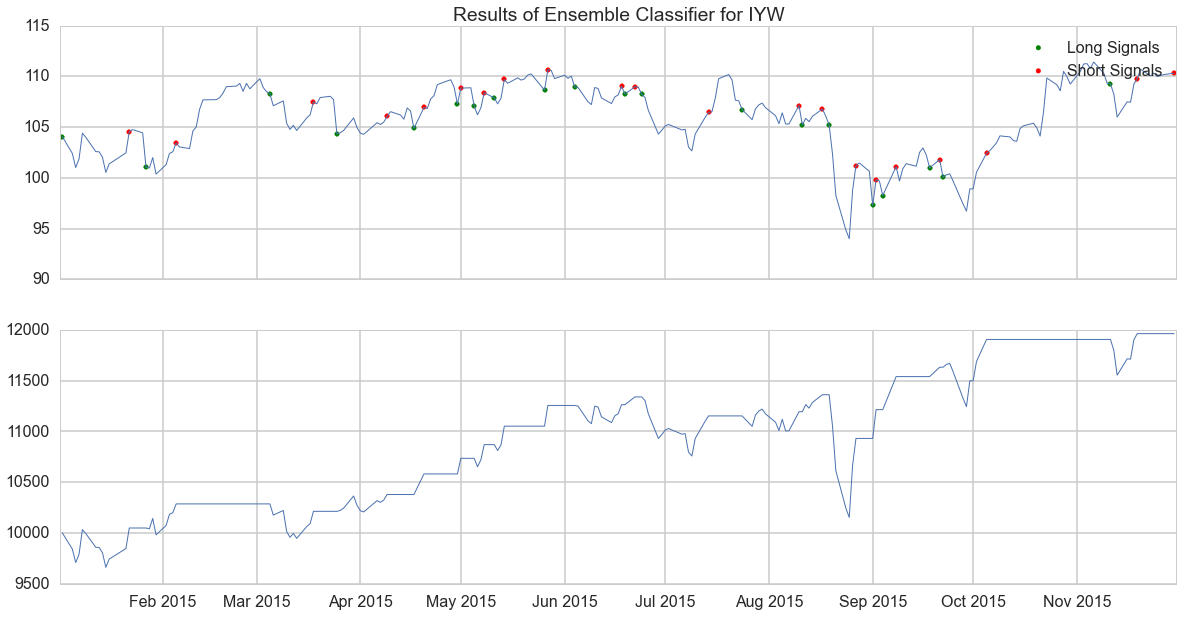

In [35]:
def plot_signal(model, title):
    fig, (ax0,ax1) = plt.subplots(nrows=2, ncols=1, figsize=(20, 10),sharex=True)
    ax0.plot(df.date[~mask], df.close[~mask], lw=1)
    short_days=zip(*evaluate(model)[5][0])[0]
    short_prices=zip(*evaluate(model)[5][0])[1]
    long_days=zip(*evaluate(model)[5][1])[0]
    long_prices=zip(*evaluate(model)[5][1])[1]
    ax0.scatter(long_days, long_prices, color='g', label="Long Signals") 
    ax0.scatter(short_days, short_prices, color='r', label="Short Signals")
    ax0.legend(frameon=False, loc='upper right')
    ax0.set_title(title)
    ax.set_ylabel(ticker +"stars")
    ax.set_xlabel("probability")
    ax1.plot(zip(*evaluate(model)[6])[0], zip(*evaluate(model)[6])[1], lw=1)

plot_signal(eclf, 'Results of Ensemble Classifier for '+ticker)